In [440]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## Part 1

In [441]:
feature_names=['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
target_names = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
iris_df = pd.read_csv('./Iris_TTT4275/iris.data', names=[*feature_names, 'target'])

iris_data = iris_df.iloc[:, :4].values
iris_targets = iris_df['target'].values

In [442]:
class MSELinearClassifier:
    def __init__(self, alpha = 0.01, n_iter = 10000, threshold = 1e-3):
        self.alpha = alpha
        self.n_iter = n_iter
        self.threshold = threshold
        self.fitted = False

    def fit(self, data, targets):
        """
        Fit a linear classifier to the provided data.

        data: shape N x n_features
        targets: shape N
        """
        if data.ndim == 1:
            data = data[:, np.newaxis]


        self.fitted = True
        
        self.target_set = list(set(targets)) #to use .index() function we wrap as list
        self.n_classes = len(self.target_set)
        self.n_features = data.shape[1]
        N = data.shape[0]

        one_hot_targets = self._one_hot_encode_targets(targets)

        self.w = np.zeros((self.n_classes, self.n_features))
        self.offset = np.zeros(self.n_classes)

        data1 = np.hstack([data, np.ones((N,1))])

        pred = self.predict(data)
        for iter in range(self.n_iter):        
            
            grad_part1 = (pred - one_hot_targets)*pred*(1 - pred)

            # gradient = 0
            # for k in range(N):
            #     gradient += np.outer(grad_part1[k], data1[k])

            gradient = np.einsum('ij,ik -> jk', grad_part1, data1) #this vectorizes the above loop
            
            update = -self.alpha*gradient

            self.w += update[:, :-1]
            self.offset += update[:, -1]

            pred = self.predict(data)

            if np.linalg.norm(update) < self.threshold:
                print(f"Fitting converged after {iter} iterations.")
                break
            
        loss = self.loss(pred, one_hot_targets)
        return loss
    

    def _one_hot_encode_targets(self, targets):
        encoded = np.zeros((targets.shape[0], self.n_classes))

        for i in range(targets.shape[0]): #not neccessarily integer labels
            j = self.target_set.index(targets[i])
            encoded[i, j] = 1

        return encoded
    
    def _sigmoid(self, x):
        return 1/(1 + np.exp(-x))

    def predict(self, data, get_class = False):
        if data.ndim == 1:
            data = data[:, np.newaxis]
            
        if not self.fitted:
            raise RuntimeError("The model must be fitted before predictions can be made")
        
        one_hot_preds = self._sigmoid(self.w@data.T + self.offset[:, np.newaxis]).T

        if get_class:
            return self.get_class(one_hot_preds)
        
        return one_hot_preds
    
    def loss(self, pred, truth):
        return 0.5*np.sum((pred - truth)**2)
    
    def get_class(self, predicted):
        targets = np.array(self.target_set)
        return targets[np.argmax(predicted, axis=1)]
    
    def score(self, test_data, test_labels):
        N = len(test_labels)
        preds = self.predict(test_data, get_class=True)
        return np.count_nonzero(test_labels == preds)/N


In [443]:
def plot_confusion_matrix(conf_matrix, score = None, plot = True, filename = None):    
    plt.figure(figsize=(6,6)) #size in inches
    sns.heatmap(conf_matrix, annot=True, linewidths=.5, square = True, cmap = 'Blues_r', xticklabels=target_names, yticklabels=target_names)
    plt.ylabel('Actual label', size=15)
    plt.xlabel('Predicted label', size=15)
    if score is not None:
        plt.title('Accuracy Score: {fscore:.{precision}f}%'.format(fscore = score*100, precision = 1), size = 20)
    if filename is not None:
        plt.savefig(filename)
    if plot:
        plt.show()
    plt.close()

### 3/5 training set, 2/5 test set

In [444]:
training_data, test_data, training_labels, test_labels = train_test_split(iris_data, iris_targets, test_size=0.4) #split the set in 3/5 training and 2/5 test

Fitting converged after 5242 iterations.
[[ 0.64989312  1.78094988 -2.94603683 -1.3975533 ]
 [-3.75048125 -3.68706879  6.38491791  3.42770964]
 [-0.06111374 -1.76465879  1.18230825 -2.39183572]] [ 0.39566868 -2.98753662  3.34374984]


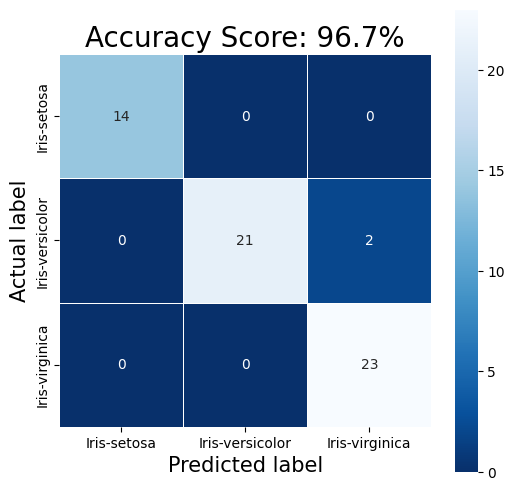

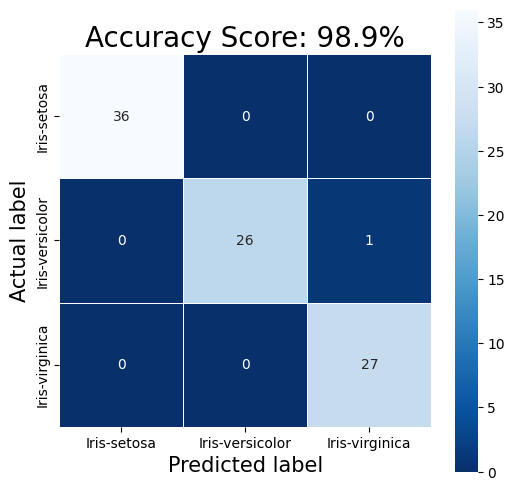

In [445]:
classifier = MSELinearClassifier()

classifier.fit(training_data, training_labels)

print(classifier.w, classifier.offset)


pred = classifier.predict(test_data, get_class = True)
score = classifier.score(test_data, test_labels)
conf_matrix = confusion_matrix(test_labels, pred)
plot_confusion_matrix(conf_matrix, score)

pred = classifier.predict(training_data, get_class = True)
score = classifier.score(training_data, training_labels)
conf_matrix = confusion_matrix(training_labels, pred)
plot_confusion_matrix(conf_matrix, score)

### 2/5 training set, 3/5 test set

In [446]:
training_data, test_data, training_labels, test_labels = train_test_split(iris_data, iris_targets, test_size=0.6) #split the set in 2/5 training and 3/5 test

Fitting converged after 3159 iterations.
[[-2.85062359 -2.33750546  4.26388955  3.66655338]
 [ 0.52579541  1.61098084 -2.58362881 -1.17446261]
 [ 0.02655811 -1.60176279  0.9961375  -2.26364879]] [-2.44420608  0.39180424  2.75420789]


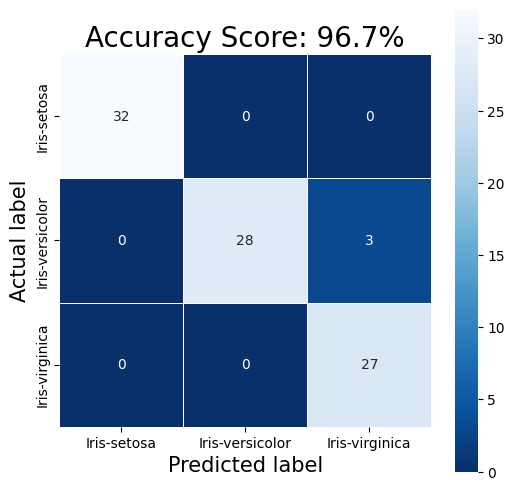

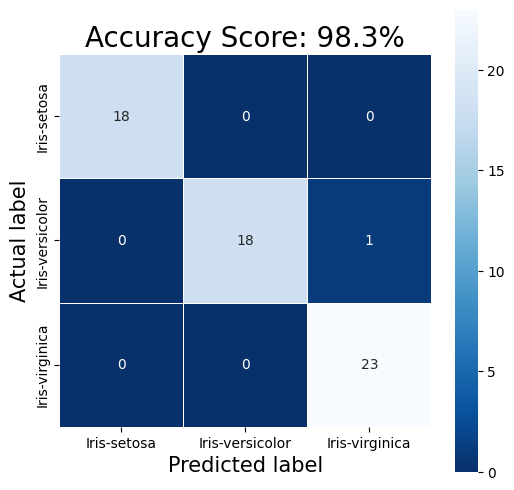

In [447]:
classifier = MSELinearClassifier()

classifier.fit(training_data, training_labels)

print(classifier.w, classifier.offset)


pred = classifier.predict(test_data, get_class = True)
score = classifier.score(test_data, test_labels)
conf_matrix = confusion_matrix(test_labels, pred)
plot_confusion_matrix(conf_matrix, score, filename="test_set_confusion_matrix.png")

pred = classifier.predict(training_data, get_class = True)
score = classifier.score(training_data, training_labels)
conf_matrix = confusion_matrix(training_labels, pred)
plot_confusion_matrix(conf_matrix, score, filename="training_set_confusion_matrix.png")

## Part 2

### Histogram of flowers per feature

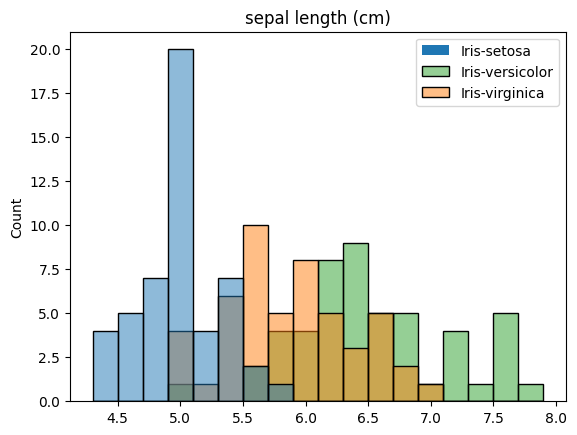

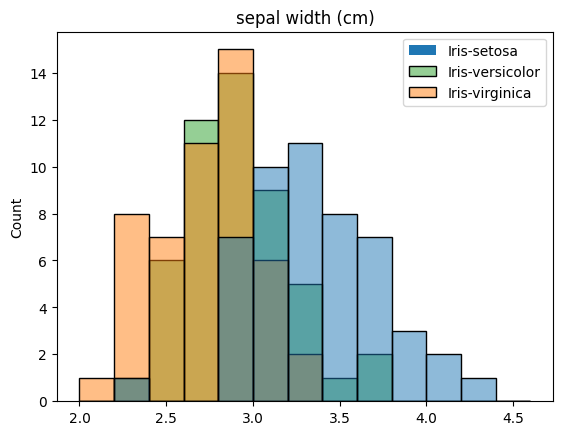

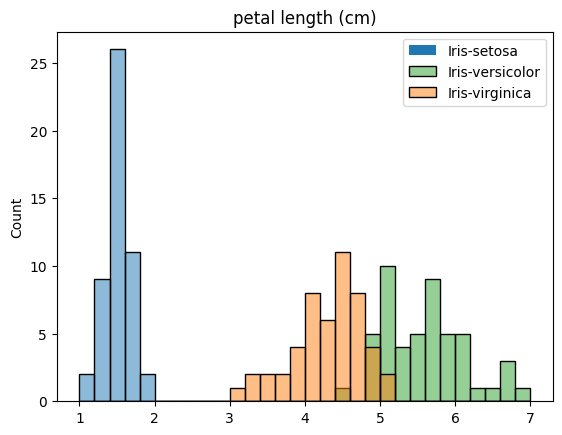

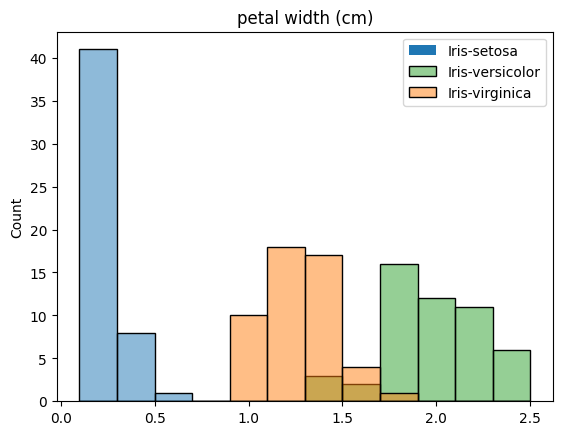

In [448]:
for i in range(len(feature_names)):
    sns.histplot(iris_data[:, i].reshape(3, 50).T, binwidth=0.2)
    plt.legend(target_names)
    plt.title(feature_names[i])
    plt.show()

### Histogram of feature per flower, less informative than plots above

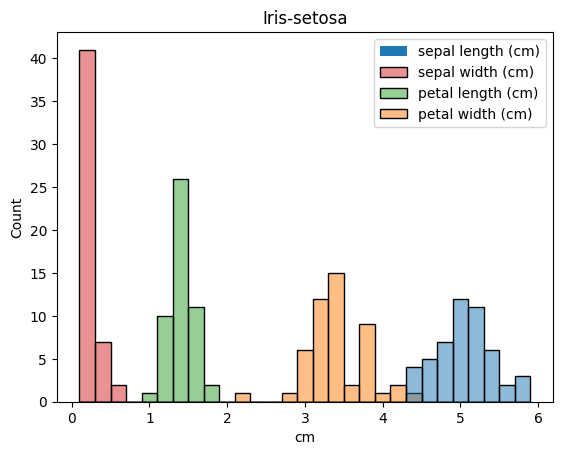

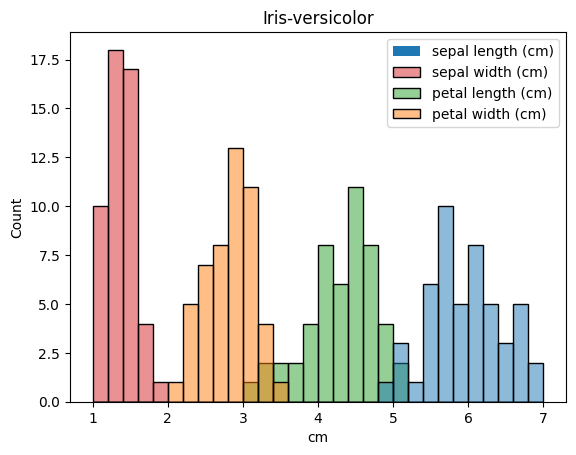

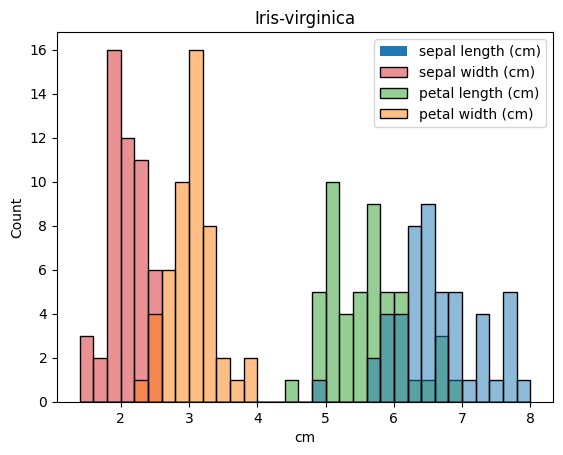

In [449]:
for tn in target_names:
    sns.histplot(iris_data[iris_targets == tn], binwidth=0.2)
    plt.legend(feature_names)
    plt.title(tn)
    plt.xlabel("cm")
    plt.show()

#### Feature 'sepal width' showing the most overlap. Remove it

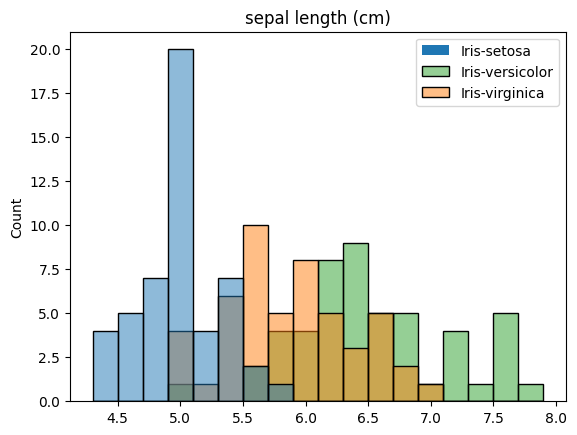

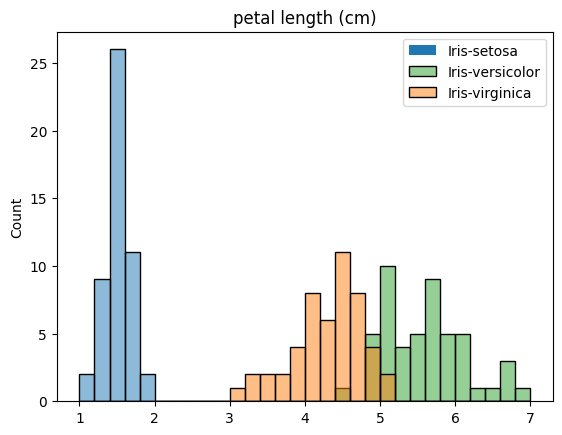

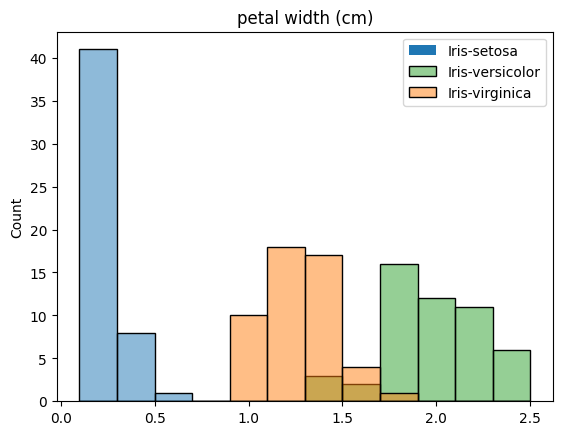

In [450]:
reduced_data = np.delete(iris_data, 1, 1)
reduced_feature_names = np.delete(feature_names, 1, 0)

for i in range(len(reduced_feature_names)):
    sns.histplot(reduced_data[:, i].reshape(3, 50).T, binwidth=0.2)
    plt.legend(target_names)
    plt.title(reduced_feature_names[i])
    plt.show()

In [451]:
training_data, test_data, training_labels, test_labels = train_test_split(reduced_data, iris_targets, test_size=0.4)

[[ 2.00172783 -3.88012796 -1.60997715]
 [-3.17055986  4.48465434  4.0545717 ]
 [-1.65945928  2.16098215 -3.217612  ]] [ 0.70286204 -9.07215239  4.8496198 ]


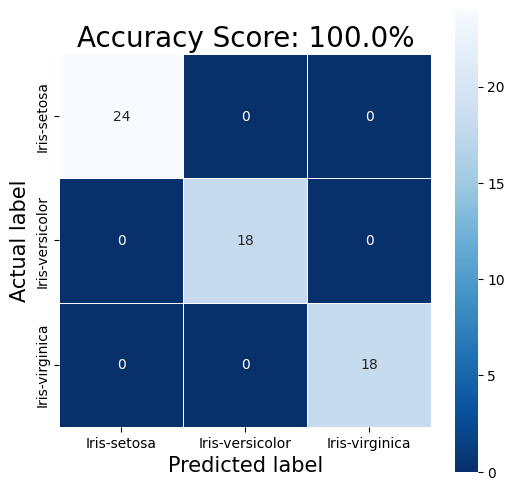

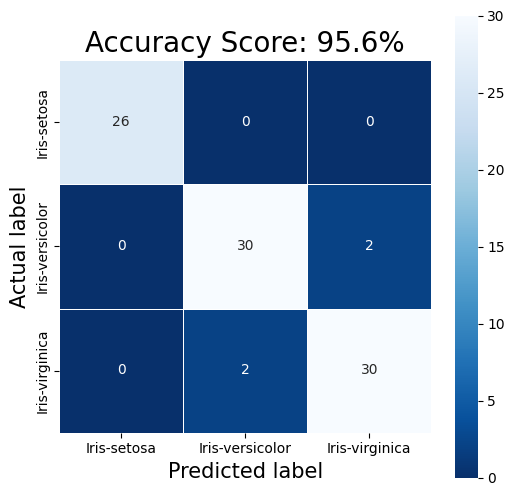

In [452]:
classifier = MSELinearClassifier()

classifier.fit(training_data, training_labels)

print(classifier.w, classifier.offset)


pred = classifier.predict(test_data, get_class = True)
score = classifier.score(test_data, test_labels)
conf_matrix = confusion_matrix(test_labels, pred)
plot_confusion_matrix(conf_matrix, score, filename="test_set_confusion_matrix.png")

pred = classifier.predict(training_data, get_class = True)
score = classifier.score(training_data, training_labels)
conf_matrix = confusion_matrix(training_labels, pred)
plot_confusion_matrix(conf_matrix, score, filename="training_set_confusion_matrix.png")

### Sepal length overlapping. Remove it

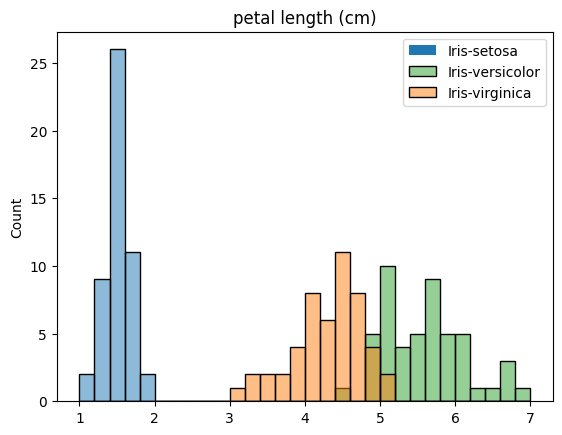

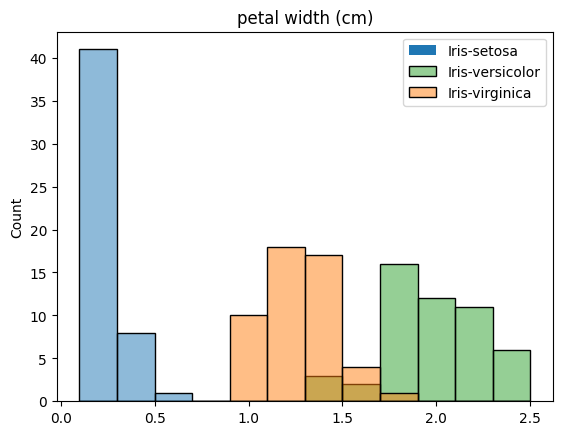

In [453]:
reduced_data2 = np.delete(reduced_data, 0, 1)
reduced_feature_names2 = np.delete(reduced_feature_names, 0, 0)

for i in range(len(reduced_feature_names2)):
    sns.histplot(reduced_data2[:, i].reshape(3, 50).T, binwidth=0.2)
    plt.legend(target_names)
    plt.title(reduced_feature_names2[i])
    plt.show()

[[ 2.00172783 -3.88012796 -1.60997715]
 [-3.17055986  4.48465434  4.0545717 ]
 [-1.65945928  2.16098215 -3.217612  ]] [ 0.70286204 -9.07215239  4.8496198 ]


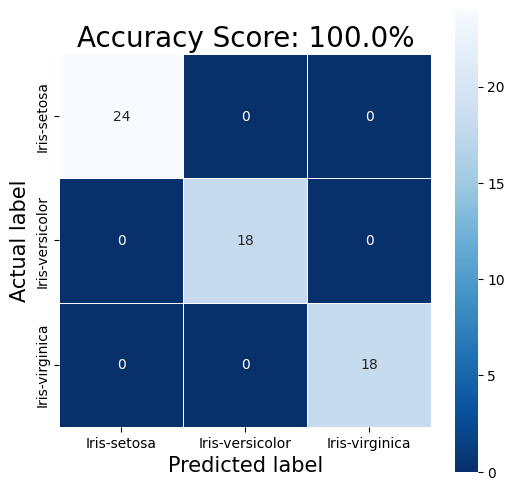

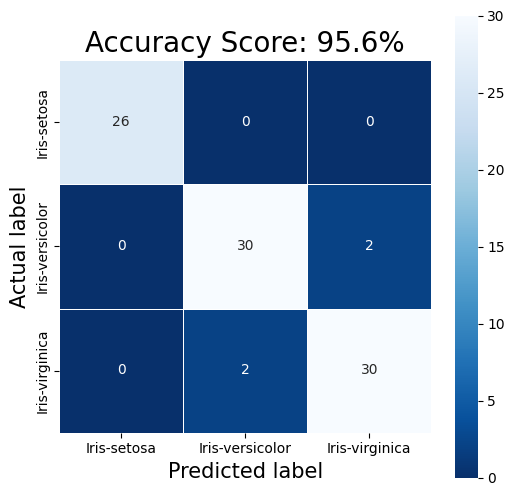

In [454]:
classifier = MSELinearClassifier()

classifier.fit(training_data, training_labels)

print(classifier.w, classifier.offset)


pred = classifier.predict(test_data, get_class = True)
score = classifier.score(test_data, test_labels)
conf_matrix = confusion_matrix(test_labels, pred)
plot_confusion_matrix(conf_matrix, score, filename="test_set_confusion_matrix.png")

pred = classifier.predict(training_data, get_class = True)
score = classifier.score(training_data, training_labels)
conf_matrix = confusion_matrix(training_labels, pred)
plot_confusion_matrix(conf_matrix, score, filename="training_set_confusion_matrix.png")

### Train on only one feature, test both petal width and length

In [455]:
training_data, test_data, training_labels, test_labels = train_test_split(iris_data[:, 2], iris_targets, test_size=0.4)

Fitting converged after 5074 iterations.
[[-2.83265463]
 [ 2.56387968]
 [ 0.27693282]] [  7.54425222 -12.38899899  -1.82528144]


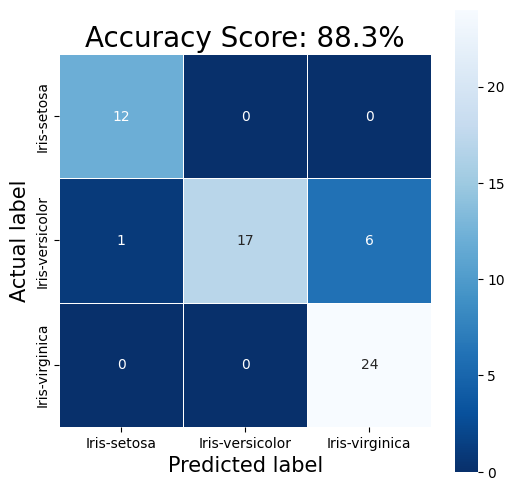

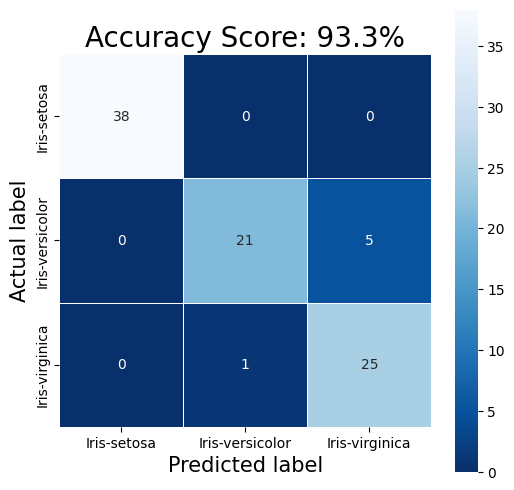

In [456]:
classifier = MSELinearClassifier()

classifier.fit(training_data, training_labels)

print(classifier.w, classifier.offset)


pred = classifier.predict(test_data, get_class = True)
score = classifier.score(test_data, test_labels)
conf_matrix = confusion_matrix(test_labels, pred)
plot_confusion_matrix(conf_matrix, score, filename="test_set_confusion_matrix.png")

pred = classifier.predict(training_data, get_class = True)
score = classifier.score(training_data, training_labels)
conf_matrix = confusion_matrix(training_labels, pred)
plot_confusion_matrix(conf_matrix, score, filename="training_set_confusion_matrix.png")

In [457]:
training_data, test_data, training_labels, test_labels = train_test_split(iris_data[:, 3], iris_targets, test_size=0.4)

Fitting converged after 3983 iterations.
[[-6.9167118 ]
 [ 5.85711867]
 [ 0.22779613]] [ 4.77933326 -9.42159548 -0.81330037]


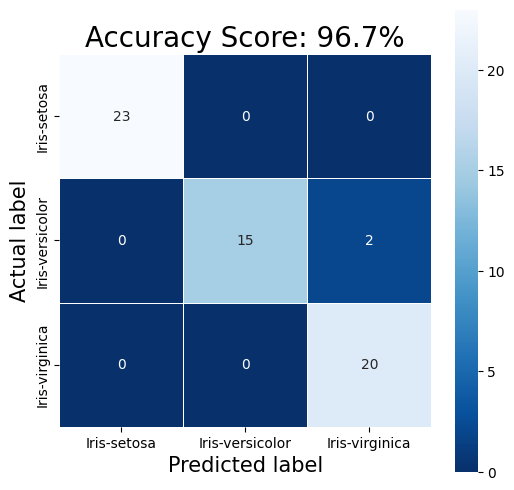

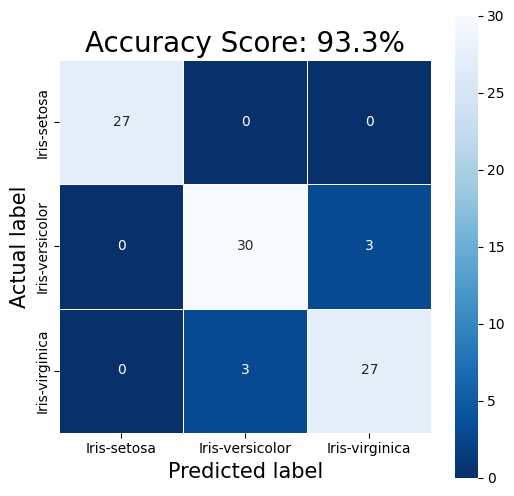

In [458]:
classifier = MSELinearClassifier()

classifier.fit(training_data, training_labels)

print(classifier.w, classifier.offset)


pred = classifier.predict(test_data, get_class = True)
score = classifier.score(test_data, test_labels)
conf_matrix = confusion_matrix(test_labels, pred)
plot_confusion_matrix(conf_matrix, score, filename="test_set_confusion_matrix.png")

pred = classifier.predict(training_data, get_class = True)
score = classifier.score(training_data, training_labels)
conf_matrix = confusion_matrix(training_labels, pred)
plot_confusion_matrix(conf_matrix, score, filename="training_set_confusion_matrix.png")

### To compare, here trained on presumed worst feature

In [459]:
training_data, test_data, training_labels, test_labels = train_test_split(iris_data[:, 1], iris_targets, test_size=0.4)

Fitting converged after 4409 iterations.
[[ 3.3791324 ]
 [-0.61481036]
 [-2.42540104]] [-11.22984987   1.11368227   6.7746565 ]


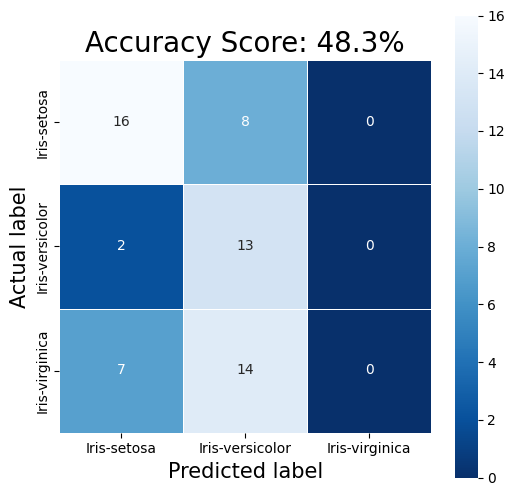

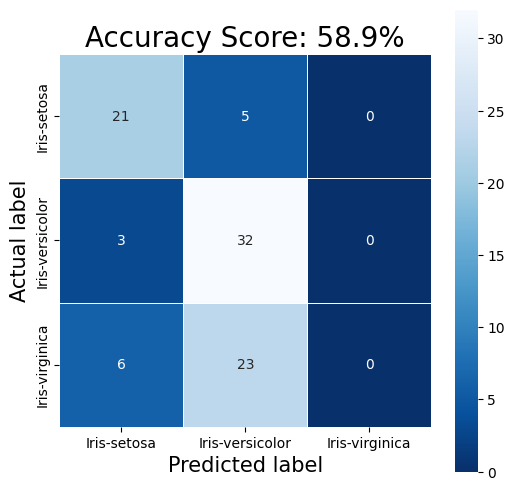

In [460]:
classifier = MSELinearClassifier()

classifier.fit(training_data, training_labels)

print(classifier.w, classifier.offset)


pred = classifier.predict(test_data, get_class = True)
score = classifier.score(test_data, test_labels)
conf_matrix = confusion_matrix(test_labels, pred)
plot_confusion_matrix(conf_matrix, score, filename="test_set_confusion_matrix.png")

pred = classifier.predict(training_data, get_class = True)
score = classifier.score(training_data, training_labels)
conf_matrix = confusion_matrix(training_labels, pred)
plot_confusion_matrix(conf_matrix, score, filename="training_set_confusion_matrix.png")

## Misc

### scatter plot feature v feature, color by label

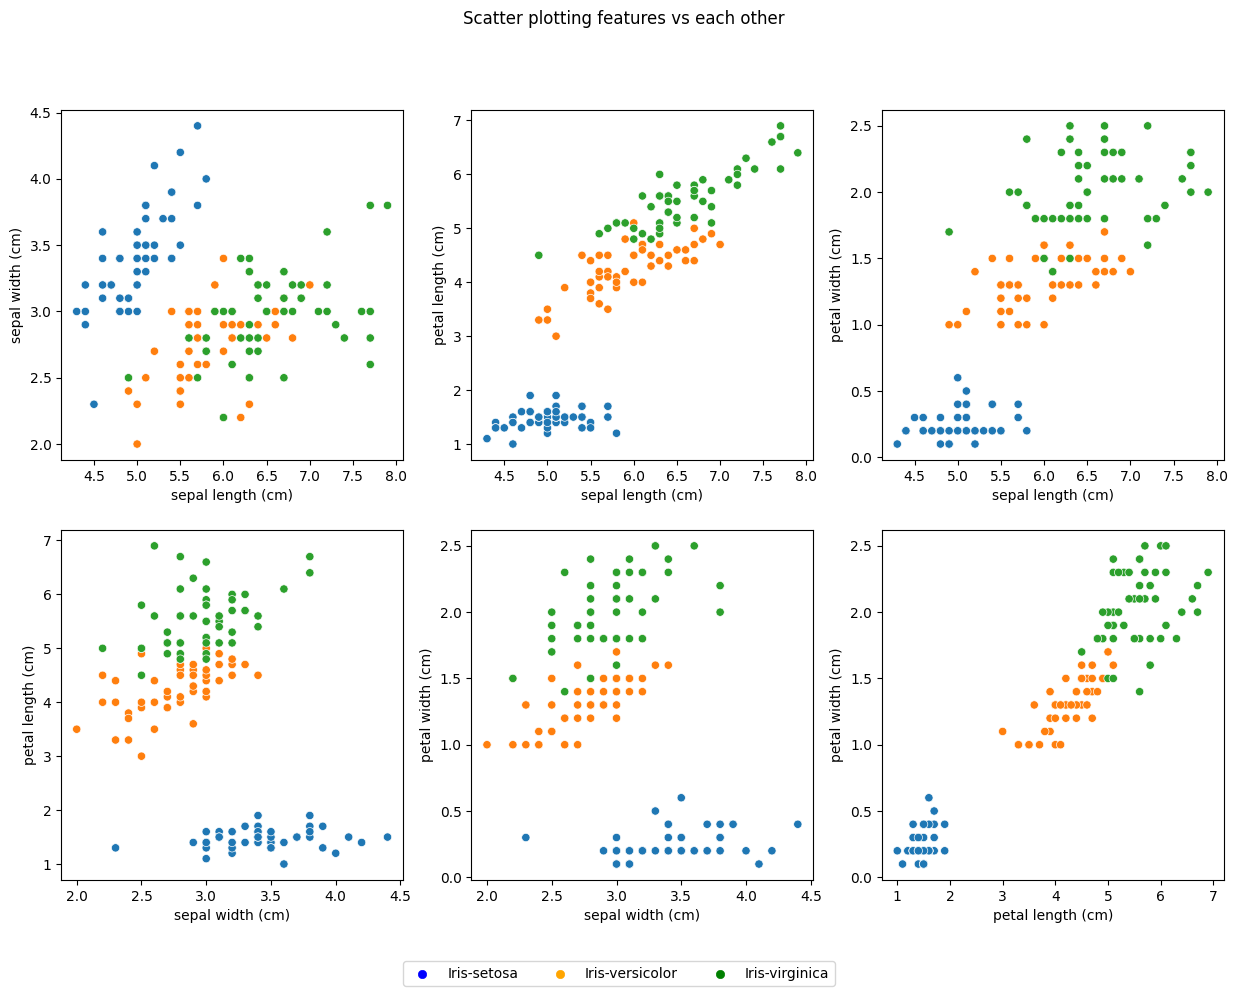

In [461]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(15, 10)

cnt = 0
for i in range(4):
    for j in range(i+1, 4):
        # Use the 'hue' argument to provide a factor variable
        sns.scatterplot(ax=axs[cnt//3, cnt%3], x=iris_df.keys()[i], y=iris_df.keys()[j], data=iris_df, hue='target', legend=False)
        cnt += 1
        
# Manually set correct legend
leg = fig.legend(target_names, loc='lower center', ncol = 3)
leg.legend_handles[0].set_color('blue')
leg.legend_handles[1].set_color('orange')
leg.legend_handles[2].set_color('green')
plt.suptitle("Scatter plotting features vs each other")
plt.show()

### 3D scatterplots

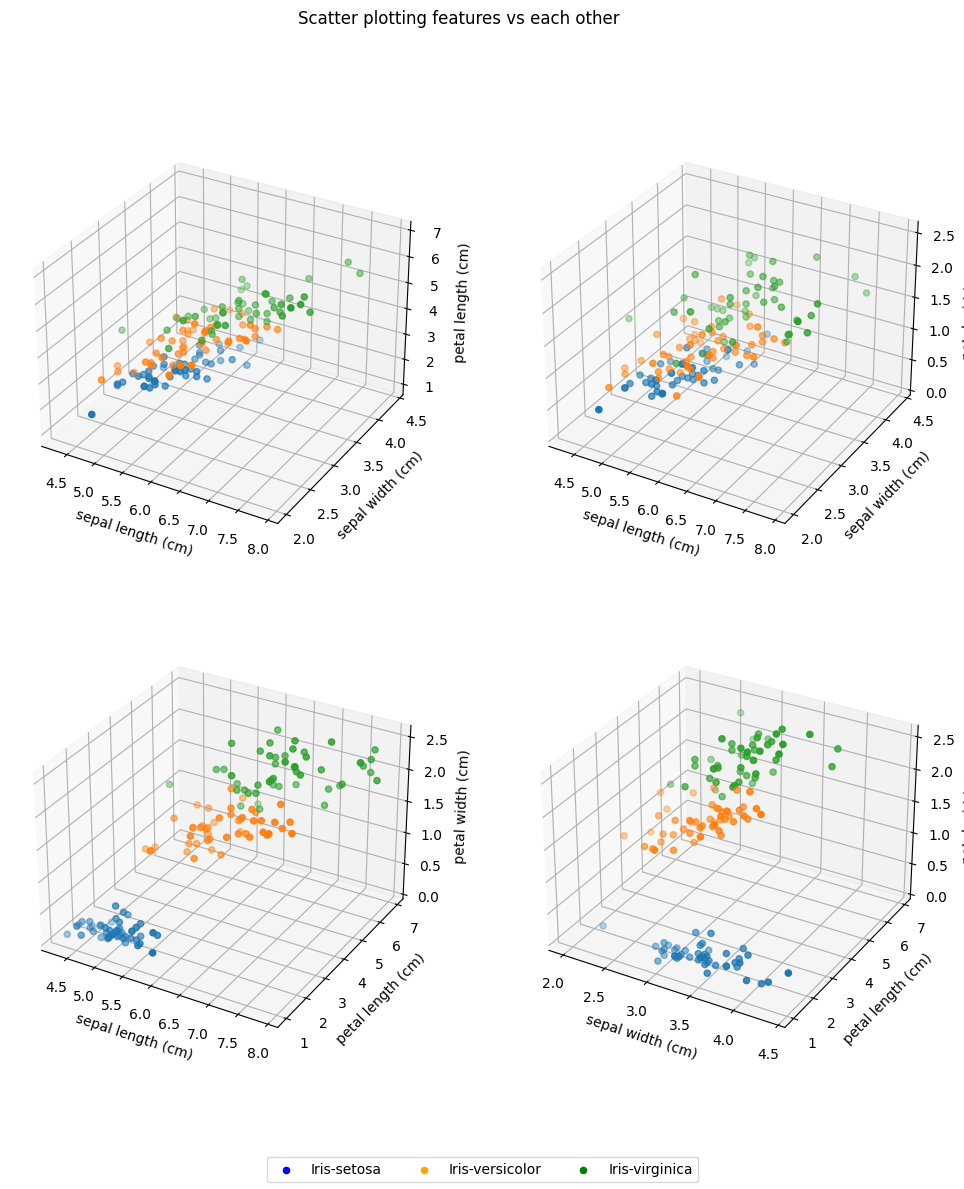

In [462]:
fig = plt.figure(figsize=(12, 12))

cnt = 0
for i in range(4):
    for j in range(i+1, 4):
        for k in range(j+1, 4):
            ax = fig.add_subplot(2, 2, cnt+1, projection='3d')
            for c in target_names:                
                ax.scatter(iris_data[iris_targets == c][:, i], iris_data[iris_targets == c][:, j], iris_data[iris_targets == c][:, k])
            ax.set_xlabel(feature_names[i])
            ax.set_ylabel(feature_names[j])
            ax.set_zlabel(feature_names[k])
            cnt += 1

# Manually set correct legend
leg = fig.legend(target_names, loc='lower center', ncol = 3)
leg.legend_handles[0].set_color('blue')
leg.legend_handles[1].set_color('orange')
leg.legend_handles[2].set_color('green')
plt.suptitle("Scatter plotting features vs each other")
plt.show()


### SKlearn classifiers for comparison

In [463]:
def linearClassification(classifier):
    name = classifier.__class__.__name__ 
    classifier.fit(training_data, training_labels)
    print("--------" + name + "--------")
   
    score = classifier.score(test_data, test_labels)
    print("Accuracy:", score*100, "%")

    return score, name

In [466]:
training_data, test_data, training_labels, test_labels = train_test_split(iris_data, iris_targets, test_size=0.4) #split the set in 3/5 training and 2/5 test

In [467]:
from sklearn.linear_model import LogisticRegression, Perceptron, PassiveAggressiveClassifier, RidgeClassifier
from sklearn.svm import LinearSVC

classifiers = [LinearSVC(), LogisticRegression(), Perceptron(), PassiveAggressiveClassifier(), RidgeClassifier()]

scores = []
names = []

for c in classifiers:
    score, name = linearClassification(c)
    scores.append(score)
    names.append(name)

--------LinearSVC--------
Accuracy: 96.66666666666667 %
--------LogisticRegression--------
Accuracy: 96.66666666666667 %
--------Perceptron--------
Accuracy: 68.33333333333333 %
--------PassiveAggressiveClassifier--------
Accuracy: 83.33333333333334 %
--------RidgeClassifier--------
Accuracy: 83.33333333333334 %


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
